# Understanding the Important Characteristics of Successful SE-Related Articles on Medium

This notebook reads in the processed features dataset (df_story_features_model_whole.csv) and runs various models on them (linear/logistic regression, SVM). The goal of the modelling task is to generate an explanatory model that is able to accurately distinguish successful from non-successful articles (as quantified by AUC / precision / recall / accuracy / etc), and to analyze the most important features that contribute to the explanatory power of the model (as quantified standard coefficient size / Wald X2 / etc).

In [94]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from IPython.core.display import display, HTML

from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from collections import Counter
pd.options.display.max_seq_items = None

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [63]:
df = pd.read_csv("../../data/features_model/df_story_features_model_whole.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5972614 entries, 0 to 5972613
Data columns (total 97 columns):
Unnamed: 0                        int64
Unnamed: 0.1                      int64
ClapCount_Card                    object
ClapCount_Story                   float64
Company                           object
CompanyURL                        object
PostID                            object
PublishedDate                     object
ReadingTime                       int64
ResponseNum_Card                  object
ResponseNum_Story                 object
VoterCount                        float64
isPaywall                         int64
TagNum                            int64
isPublication                     int64
AuthorArticlesClap_mean           float64
AuthorArticlesClap_median         float64
AuthorArticlesClap_count          int64
AuthorArticlesClap_sum            float64
AuthorArticlesResponse_mean       float64
AuthorArticlesResponse_median     float64
AuthorArticlesResponse_cou

# Generate binary dependent variable (for logit / SVM)

In [86]:
# # Median split: Doesnt work if the median claps is 0
# df['isSuccessful'] = (df['ClapCount_Story'] > df['ClapCount_Story'].median()).astype(int)

# # Below or above the top 25% of claps
threshold = 0.25
df['isSuccessful'] = (df['ClapCount_Story'] > df.sort_values(by=['ClapCount_Story'], ascending=False).iloc[int(len(df)*threshold)]['ClapCount_Story'])

# Create balanced class sample and split into train / test (80/20)

In [97]:

# # Sample with balanced data classes
# # Sample N samples, and select an equal amount of successful and non-successful articles
# # Note that because there are fewer successful articles than non-successful articles, only a fraction of the initial sample are used
# # e.g. from a sample of 50,000, we obtain 12,000 successful articles and so we must also have only 12,000 non-successful articles
sample =  df.sample(50000).groupby('isSuccessful', group_keys=False)
sample = sample.apply(lambda x: x.sample(sample.size().min()).reset_index(drop=True))

print("Number of successful articles:", len(sample[sample.isSuccessful == False]))
print("Number of unsuccessful articles:", len(sample[sample.isSuccessful == True]))

# # Make a 80/20 training split
mask = np.random.rand(len(sample)) < 0.8
train = sample[mask]
test = sample[~mask]

print("Median clap count of training set", train['ClapCount_Story'].median())

Number of successful articles: 12281
Number of unsuccessful articles: 12281
Median clap count of training set 14.0


# Select Features

Some of the features are commented out if they are determined to be too closely related to the dependent variable. For example, "AuthorArticlesClap_sum/median/mean" is not valid since most of the authors have only one article and so the metric is equal to "ClapCount", which means we would predicting the dependent variable using the dependent variable. 

In [98]:
# # Complete feature set
features = ["isPaywall","isPublication",
"SentimentPolarity","SentimentSubjectivity",
"WordNum","TextSyllableNum","TextLexiconNum","TextSentenceNum",
"ReadabilityFleschEase","ReadabilitySMOG","ReadabilityFleschKincaid","ReadabilityColemanLiau","ReadabilityARI","ReadabilityDaleChall","ReadabilityDifficultWordsNum","ReadabilityLinsearWriteFormula","ReadabilityGunningFog","ReadabilityReadingTime","ReadabilityConsensus",
"ReadingTime","HasFeaturedImage","CodeInlineNum","TagNum","CodeBlockNum",
"CodeBlockLengthSum","CodeBlockLengthMedian","CodeBlockLengthMean","CodeBlockLengthStd","CodeBlockLengthMin","CodeBlockLengthMax",
"ListOlNum","ListOlSum","ListOlMedian","ListOlMean","ListOlStd","ListOlMin","ListOlMax",
"ListUlNum","ListUlSum","ListUlMedian","ListUlMean","ListUlStd","ListUlMin","ListUlMax","ImgNum","LinkNum","HlightNum",
"ParagraphNum","ItalicNum","BoldNum",
# "AuthorArticlesClap_mean","AuthorArticlesClap_median","AuthorArticlesClap_count","AuthorArticlesClap_sum",
"AuthorArticlesClap_count",
#"AuthorArticlesResponse_median","AuthorArticlesResponse_sum",
"AuthorArticlesResponse_mean","AuthorArticlesVoter_mean","AuthorArticlesVoter_median","AuthorArticlesVoter_sum",
"TagUseSum","TagUseMean","TagUseMedian","TagClapSum","TagClapMean","TagClapMedian",
#"PublicationClap_mean","PublicationClap_median","PublicationClap_count","PublicationClap_sum",
"PublicationReadingTime_mean","PublicationReadingTime_median","PublicationReadingTime_sum","PublicationVoter_mean","PublicationVoter_median","PublicationVoter_sum","PublicationisPaywall_mean","PublicationisPaywall_median","PublicationisPaywall_sum"
]

print(len(features))

# # For continuous regression (linear reg)
# depvar = 'ClapCount_Story'

# # For categorical regression (logistic reg / SVM)
depvar = 'isSuccessful'


xTrain = train[features]
yTrain = train[depvar]

xTest = test[features]
yTest = test[depvar]

70


# Check NA columns

In [99]:
pd.set_option('display.max_rows', 1000)
print(len(((df[df['TagNum']==0])))/len(df))
print(len(xTrain.isna().any())/len(xTrain))

0.0010228352275904655
0.0035732516590096988


# SKLearn LinReg

In [100]:
reg = LinearRegression(normalize=True).fit(xTrain, yTrain)

#sklearn preprocess normalize

In [101]:
reg.score(xTrain,yTrain)

0.27049636408886946

# statsmodel LinReg

In [ ]:
mod = sm.OLS(yTrain,xTrain.astype(float))
fii = mod.fit()

print(dir(fii))
p_values = fii.pvalues
print(p_values[p_values<0.05].sort_values(ascending=True))
print(fii.summary())

# Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(max_iter=1200000)
rfe = RFE(model, 20)
fit = rfe.fit(xTrain, yTrain)
print(fit.score(xTrain, yTrain))
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))


# SKLearn Logistic Regression

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
logit = LogisticRegression()
logit.fit(xTrain,yTrain)
logit.score(xTrain,yTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

0.6426237876467585

In [104]:
# Get AUC
from sklearn import metrics

yPreds = logit.predict(xTrain)
print("Predict", Counter(yPreds))
# print(type(yPreds))
print("Truth", Counter(yTrain))

# print(yPreds)
fpr, tpr, thresholds = metrics.roc_curve(yTrain, yPreds)
print(metrics.auc(fpr, tpr))

Predict Counter({True: 13310, False: 6280})
Truth Counter({True: 9851, False: 9739})
0.6416025882893016


In [ ]:
len(xTrain)

# SKLearn SVC (too slow)

In [ ]:

# # SVC is taking too long, unless I misconfigured something.
# # For reference, SVC on iris dataset with 150 samples takes ~20 seconds for me
# # So, it doesn't seem feasible considering our sample size is thousands - millions

# Instead, use SGDClassifier with loss='hinge' which is a linear SVM.


# from matplotlib import pyplot as plt
# from sklearn import svm
    
# s = svm.SVC(kernel = 'linear', gamma='auto')
# s.fit(xTrain,yTrain)

# pd.Series(abs(s.coef_[0]), index=features).nlargest(10).plot(kind='barh')

#  SKLearn SGDClassifier SVM

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

0.781725370086779

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_estimator_type', '_final_estimator', '_fit', '_get_param_names', '_get_params', '_get_tags', '_inverse_transform', '_iter', '_log_message', '_pairwise', '_replace_estimator', '_required_parameters', '_set_params', '_transform', '_validate_names', '_validate_steps', 'classes_', 'decision_function', 'fit', 'fit_predict', 'fit_transform', 'get_params', 'inverse_transform', 'memory', 'named_steps', 'predict', 'predict_log_proba', 'predict_proba', 'score', 'set_params', 'steps', 'transform', 'verbose']
Predict Counter({False: 11521, True: 8069})
Truth Counte

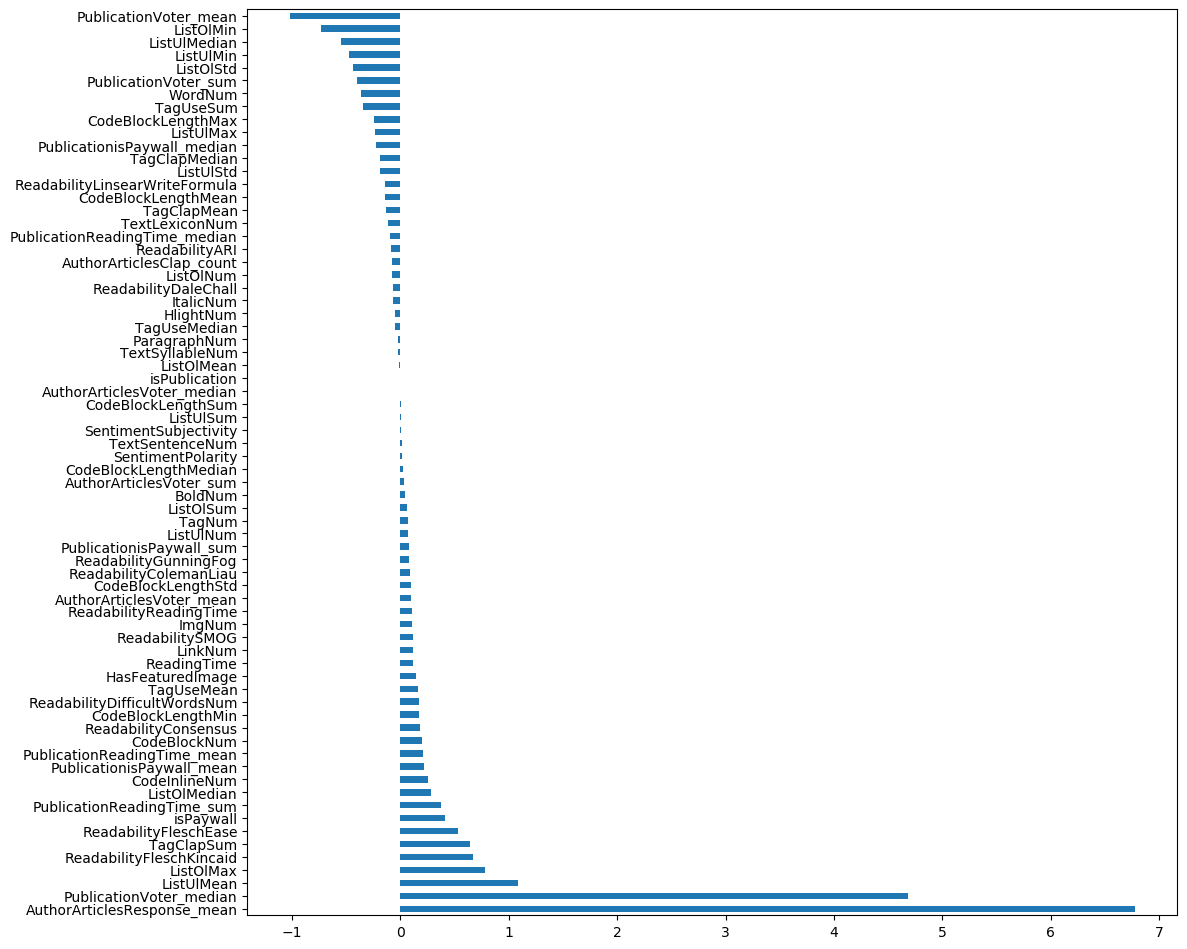

In [106]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sgdclf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3, n_jobs=-1))
sgdclf.fit(xTrain, yTrain)
sgdclf.score(xTrain, yTrain)
print(dir(sgdclf))


yPreds = sgdclf.predict(xTrain)
print("Predict", Counter(yPreds))
# print(type(yPreds))
print("Truth", Counter(yTrain))

# print(yPreds)
fpr, tpr, thresholds = metrics.roc_curve(yTrain, yPreds)
print(metrics.auc(fpr, tpr))

pd.Series(sgdclf.named_steps['sgdclassifier'].coef_[0], index=features).nlargest(len(features)).plot(kind='barh')

# SKLearn LinearSVC

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=0,
                           tol=1e-05, verbose=0))],
         verbose=False)

0.7729453802960694

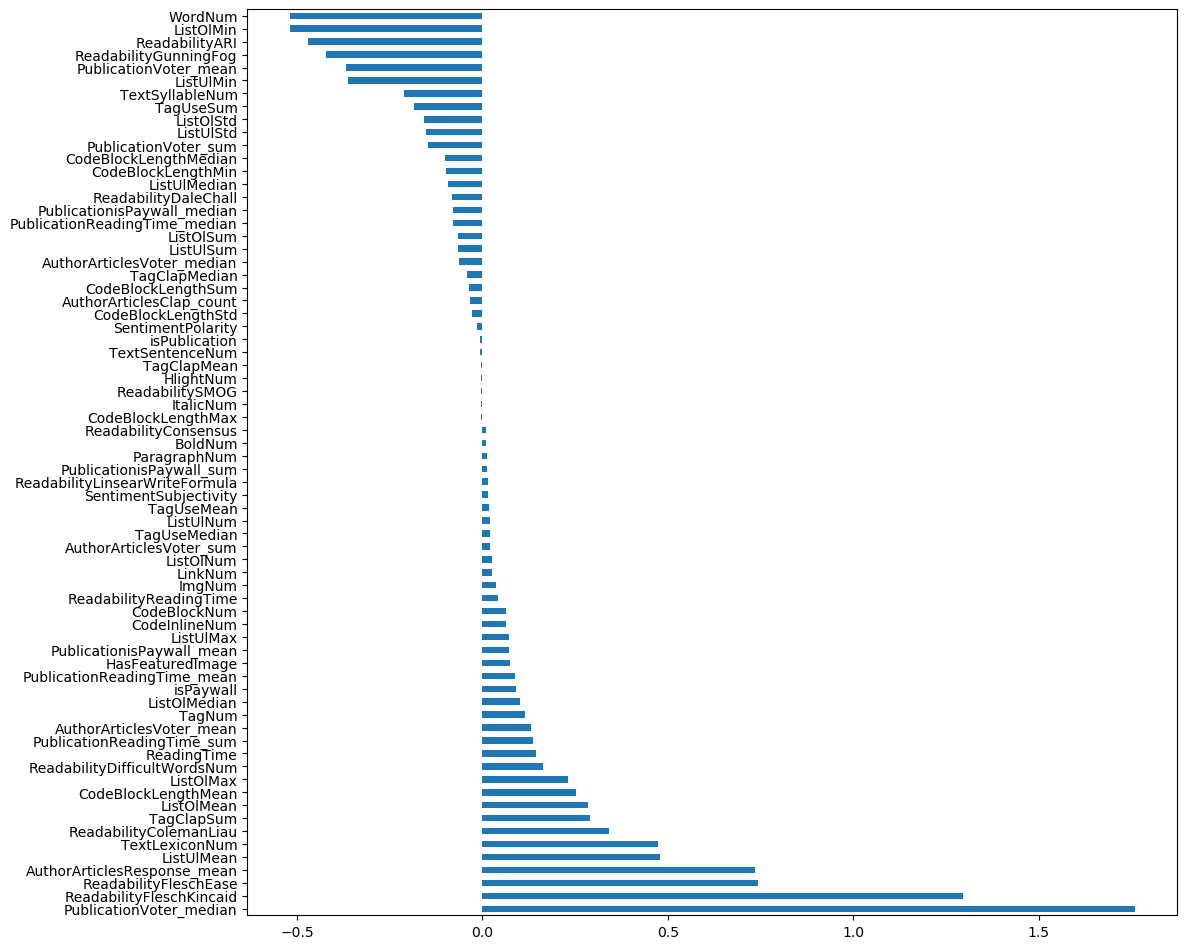

In [111]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification 

clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))

clf.fit(xTrain, yTrain)
clf.score(xTrain,yTrain)
pd.Series(clf.named_steps['linearsvc'].coef_[0], index=features).nlargest(len(features)).plot(kind='barh')

# Iris dataset benchmarks 
## From [[link]](https://stackoverflow.com/a/32025662)
On my computer, it takes ~21s for normal SVM, 1.6s for bagging classifier SVM, and 0.02s for random forest.

In [10]:
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

iris = datasets.load_iris()
X, y = iris.data, iris.target

X = np.repeat(X, 100, axis=0)
y = np.repeat(y, 100, axis=0)
start = time.time()
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(X, y)
end = time.time()
print("Single SVC", end - start, clf.score(X,y))
proba = clf.predict_proba(X)

n_estimators = 10
start = time.time()
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf.fit(X, y)
end = time.time()
print("Bagging SVC", end - start, clf.score(X,y))
proba = clf.predict_proba(X)

start = time.time()
clf = RandomForestClassifier(min_samples_leaf=20)
clf.fit(X, y)
end = time.time()
print("Random Forest", end - start, clf.score(X,y))
proba = clf.predict_proba(X)


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='auto_deprecated', kernel='linear',
                                  max_iter=-1, probability=True,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

Single SVC 21.410616636276245 0.9666666666666667


OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=SVC(C=1.0,
                                                                   cache_size=200,
                                                                   class_weight='balanced',
                                                                   coef0=0.0,
                                                                   decision_function_shape='ovr',
                                                                   degree=3,
                                                                   gamma='auto_deprecated',
                                                                   kernel='linear',
                                                                   max_iter=-1,
                                                                   probability=True,
                                                                   random_state=None,
                                                                   shri

Bagging SVC 1.5999994277954102 0.96


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Random Forest 0.02699756622314453 1.0
